In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from ultralytics import YOLO
import random
import math
import torch
from PIL import Image
import shutil
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Normalize, RandomRotation, ColorJitter, RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor
import torchvision.transforms.functional as F
import evaluate

/Users/chuamingfeng/Desktop/Synapxe/pill_classification/pilldetection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('imagefolder', data_dir=os.path.join('..', 'data', 'processed2'))

Resolving data files: 100%|██████████| 401/401 [00:00<00:00, 265370.13it/s]


In [3]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [4]:
class ResizeWithPad:
    def __init__(self, w=224, h=224):
        self.w = w
        self.h = h

    def __call__(self, image):
        w_1, h_1 = image.size

        # Calculate aspect ratios
        aspect_ratio_h = self.h / h_1
        aspect_ratio_w = self.w / w_1

        # Determine the new size while maintaining aspect ratio
        if aspect_ratio_h < aspect_ratio_w:
            new_h = self.h
            new_w = int(w_1 * aspect_ratio_h)
        else:
            new_w = self.w
            new_h = int(h_1 * aspect_ratio_w)

        # Resize the image
        image = F.resize(image, [new_h, new_w])

        # Pad the image to the desired width and height
        pad_left = (self.w - new_w) // 2
        pad_right = self.w - new_w - pad_left
        pad_top = (self.h - new_h) // 2
        pad_bottom = self.h - new_h - pad_top

        image = F.pad(image, (pad_left, pad_top, pad_right, pad_bottom))

        return image


In [5]:
normalize = Normalize(mean=image_mean, std=image_std)
train_transforms = Compose(
    [
        ResizeWithPad(size, size),
        RandomRotation(45),
        ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=0.1),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
    ]
)
val_transforms = Compose(
    [
        ResizeWithPad(224, 224),
        ToTensor(),
        normalize
    ]
)
test_transforms = Compose(
    [
        ResizeWithPad(224, 224),
        ToTensor(),
        normalize
    ]
)

In [6]:
def preprocess_train(data):
    data["pixel_values"] = [train_transforms(image) for image in data["image"]]
    return data
def preprocess_val(data):
    data["pixel_values"] = [val_transforms(image) for image in data["image"]]
    return data
def preprocess_test(data):
    data["pixel_values"] = [test_transforms(image) for image in data["image"]]
    return data

In [7]:
# split up training into training + validation
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [8]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


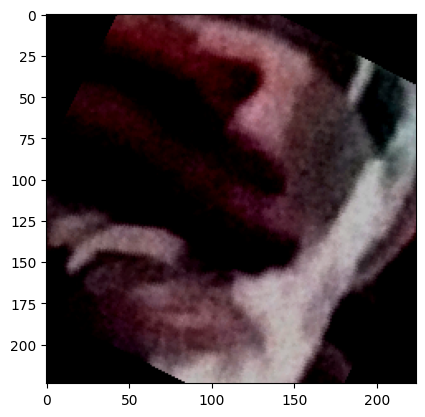

In [9]:
img = train_ds[0]['pixel_values']
plt.imshow(img.permute(1, 2, 0))

In [10]:
accuracy_metric = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [11]:
labels = train_ds.features['label'].names

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
  output_dir=os.path.join('..', 'vit-pills'),
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=100,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA or NPU devices or certain XPU devices (with IPEX).